In [1]:
import json
import heapq
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

import visualize

In [2]:
class Station:
    def __init__(self, name, x, y):
        self.name = name
        self.x = x
        self.y = y
        
        self.g = np.inf         # Path cost
        self.h = 0              # Heuristic cost
        self.f = 0              # Total cost 
        
        self.parent = None      # Parent node
        self.connections = {}   # Neighbouring stations
        self.prev_line = None   # Previous line taken to reach this station

    def add_connection(self, station, line, travel_time):
        self.connections[station] = (line, travel_time)

    def __lt__(self, other):
        return self.f < other.f
    
    def __str__(self):
        return self.name
    
class Line:
    def __init__(self, name, wait_time):
        self.name = name
        self.wait_time = wait_time

    def __str__(self):
        return self.name

In [3]:
def build_subway_graph():
    subway = json.load(open('subway.json', 'r'))

    # Turn stations into objects and store them by their names
    stations = {}
    for stop_name, stop_location in subway["locations"].items():
        station = Station(name=stop_name, x=stop_location[0], y=stop_location[1])
        stations[stop_name] = station

    # Turn lines into objects
    lines = {}
    for line_name, line_attr in subway["lines"].items():
        line = Line(name=line_name, wait_time=line_attr["wait_time"])
        lines[line_name] = line

    # Add connections between stations
    for line_name, line_attr in subway["lines"].items():
        stops = line_attr["stops"]
        for stop in stops:
            start = stop["start"]
            end = stop["end"]
            stations[start].add_connection(station=stations[end], line=lines[line_name], travel_time=stop["travel_time"])
            stations[end].add_connection(station=stations[start], line=lines[line_name], travel_time=stop["travel_time"])

    return stations, lines

In [4]:
def get_heuristic(a, b):
    """ 
    :param a: node object representing point 1
    :param b: node object representing point 2

    :return: Euclidean distance between two points
    """
    return np.sqrt((a.x - b.x)**2 + (a.y - b.y)**2)

In [5]:
def astar(start, end):
    """
    :param start: node object representing start point
    :param end: node object representing end point

    :return: the optimal path found
    """
    open_list = []      # Potential nodes to explore
    closed_list = []    # Nodes that have already been explored

    heapq.heappush(open_list, start)
    start.g = 0         # Starting station has 0 distance to itself

    # Loop until you reach the end
    while open_list:
        # Explore the next frontier station (lowest f value)
        curr = heapq.heappop(open_list)
        closed_list.append(curr)

        # If the end is found, work backwards to build the path
        if curr == end:
            path = []
            while curr:
                path.append(curr)
                curr = curr.parent
            return path[::-1]

        # Else, update all neighbours
        for next in curr.connections.keys():
            # Don't explore any stations in the closed list
            if next in closed_list:
                continue

            # Calculate the time to travel to the next station + wait time for switching lines
            line, travel_time = curr.connections[next]
            if curr.prev_line is None or curr.prev_line.name != line.name:
                travel_time += line.wait_time
                
            # If a shorter path to the next station is found, update its values
            new_distance = curr.g + travel_time
            if new_distance < next.g:
                next.parent = curr
                next.g = new_distance
                next.h = get_heuristic(next, end)
                next.f = next.g + next.h
                next.prev_line = line

                # If the next station isn't in the open list (frontier), add it
                if next not in open_list:
                    heapq.heappush(open_list, next)

    # Path not found
    return None

Shortest path using A*: ['145 St', '14 St W', '14 St', '14 St-Union Sq', 'Canal St', 'Whitehall St-South Ferry', 'South Ferry']


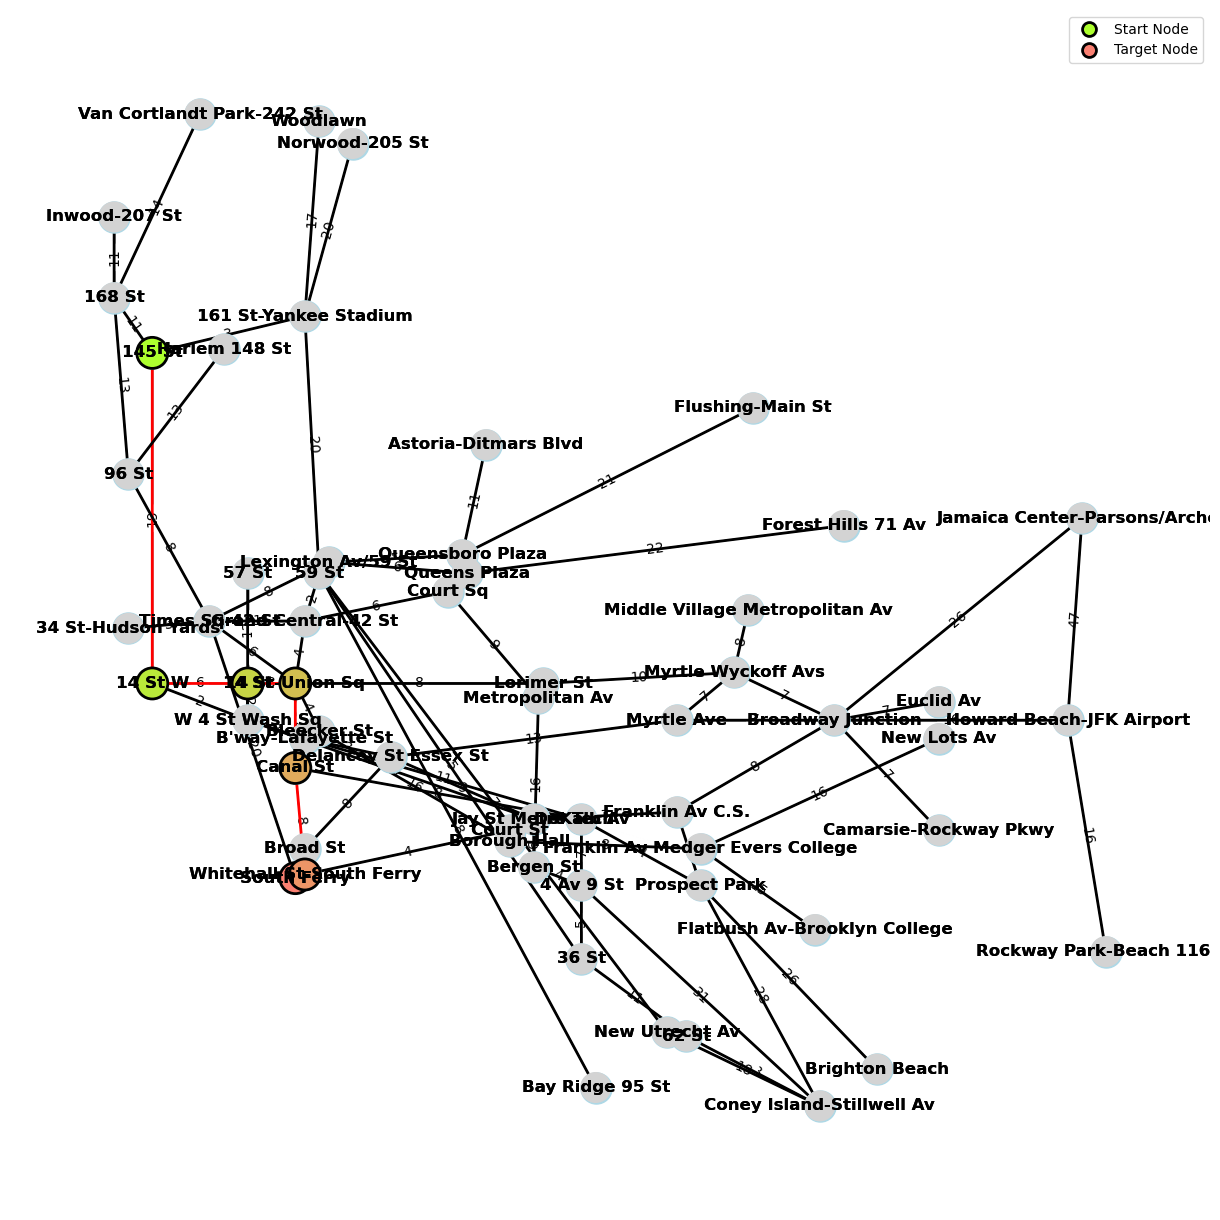

In [6]:
stations, lines = build_subway_graph()
nodes, edges = visualize.get_nodes_and_edges_subway(stations)

start_station = "145 St"
end_station = "South Ferry"

# Compute shortest path using A* algorithm
path_a_star = astar(stations[start_station], stations[end_station])
path_a_star = [station.name for station in path_a_star]
print("Shortest path using A*:", path_a_star)

G = visualize.get_graph(nodes, edges, plot=False, directed=False)
visualize.draw_graph_path(G, nodes, path_a_star, directed=False)

Shortest path using Dijkstra: ['145 St', '14 St W', 'W 4 St Wash Sq', '14 St', '14 St-Union Sq', 'Canal St', 'Whitehall St-South Ferry', 'South Ferry']


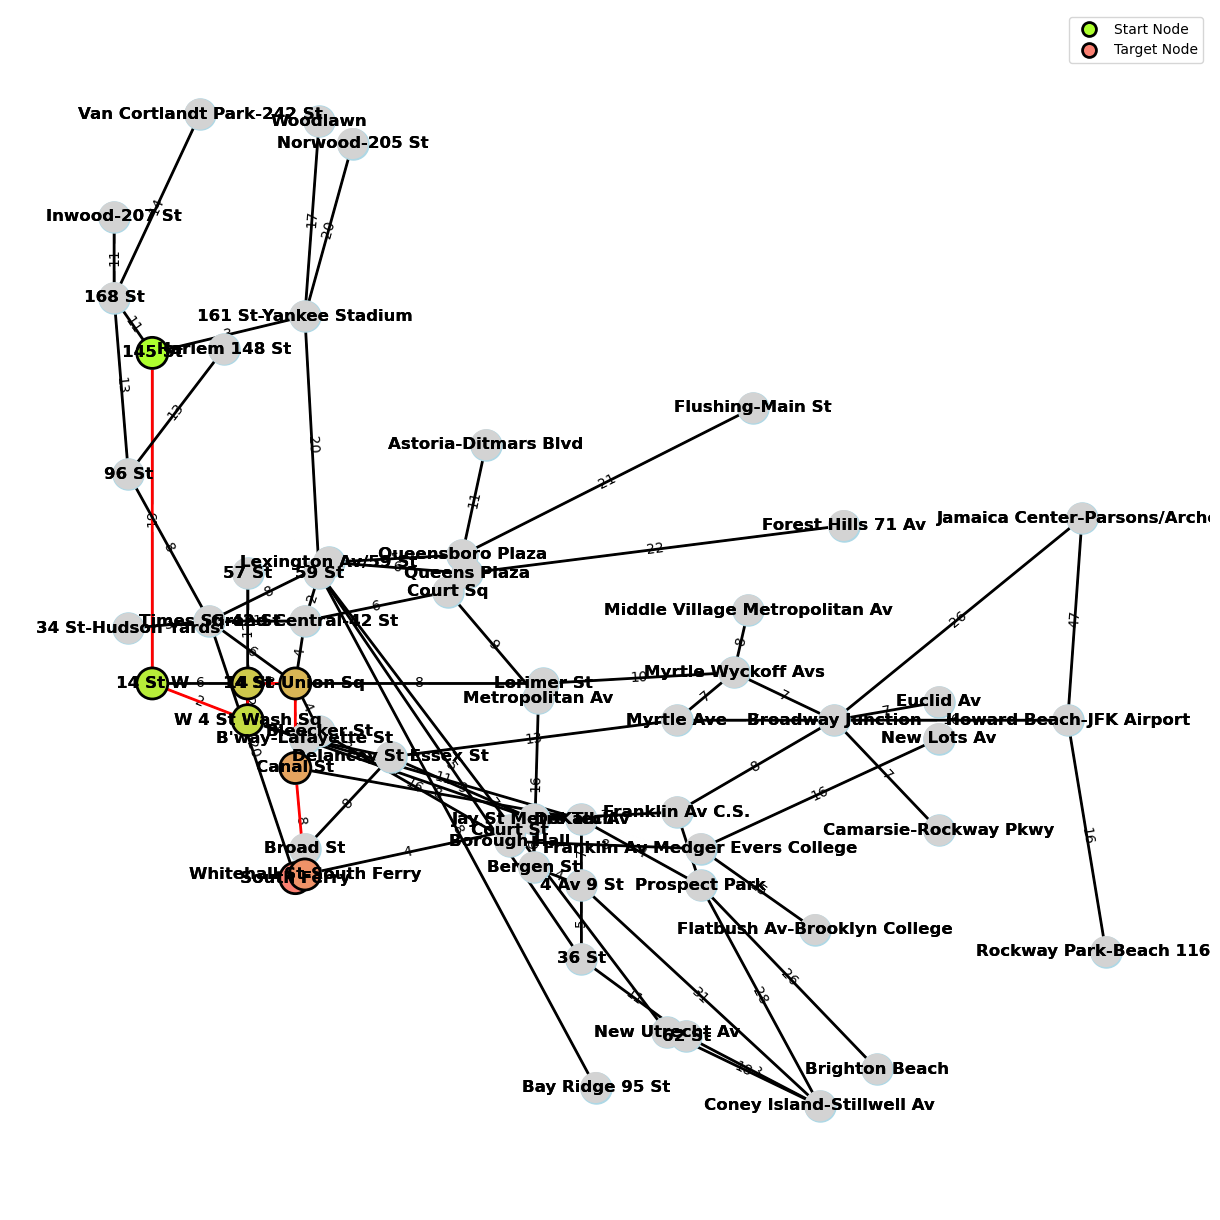

In [7]:
# Compute shortest path using Dijkstra's algorithm
G = visualize.get_graph(nodes, edges, plot=False, directed=False)

path_dijkstra = nx.dijkstra_path(G, source=start_station, target=end_station)
print("Shortest path using Dijkstra:", path_dijkstra)

visualize.draw_graph_path(G, nodes, path_dijkstra, directed=False)